In [24]:
import sys, os
import numpy as np
import pandas as pd
import scipy.sparse
import networkx as nx
import matplotlib.pyplot as plt

In [104]:
class IBDtoGDF:
    def __init__(self, ibd_file=None, ibd_array=None):
        assert not (ibd_file and ibd_array)
        assert (ibd_file or ibd_array)
        
        self.total_ibd_array = None
        self.ninds = None
        self.pos = None
        self.graph_params = None
        
        self.ibd_array = ibd_array
        if ibd_file is not None:
            self.ibd_array = np.load(ibd_file)['ibd_array']
            
        self.ibd_df = pd.DataFrame(self.ibd_array, columns=['ind1', 'ind2', 'start', 'end'])
        self.ibd_df['len'] = self.ibd_df['end'] - self.ibd_df['start']
        
        # Could check inds are all ints first
        self.inds = list(set(self.ibd_df[['ind1', 'ind2']].values.astype(int).ravel()))
        self.ninds = max(self.inds)
        
    def get_pairwise_total_length(self, maxrows=None):
        self.total_ibd_array = scipy.sparse.lil_matrix((self.ninds + 1, self.ninds + 1))
        
        for i, row in self.ibd_df.iterrows():
            ind1, ind2 = sorted([int(row.ind1), int(row.ind2)])
            self.total_ibd_array[ind1, ind2] += row.len
            if maxrows is not None and i > maxrows:
                break
                
    def build_graph(self, k=None, iterations=None, outfile=None):
        G = nx.Graph()
        coo = self.total_ibd_array.tocoo()
        max_len = coo.data.max()
        for r, c, d in zip(coo.row, coo.col, coo.data):
            G.add_edge(r, c, weight=d / max_len)
            
        if outfile is not None:
            nx.nx_pydot.write_dot(G, os.path.expanduser(outfile))
            
        self.graph_params = {'k': k, 'iterations': iterations}
        pos = nx.spring_layout(G, k=k, iterations=iterations)
        self.pos = np.vstack(list(pos.values()))
    
    def plot_graph(self, **plot_args):
        if self.pos is None:
            raise ValueError("Must run 'build_graph' before plotting!")
        
        p_args = {'s': 1, 'alpha': 0.5}
        for k, v in plot_args.items():
            p_args[k] = v
            
        plt.scatter(self.pos[:, 0], self.pos[:, 1], **p_args)
        plt.title(str(self.graph_params['iterations']) + ' iterations')
        plt.show()
        

In [107]:
ibd_file = os.path.expanduser(
    '~/project/wf_coalescent/results/IBD/' +\
    'Ne500_samples250/2019-09-17_12-51-45_Ne500_samplesize250_maxtime5_modelDTWF_ibd.npz')

ibd_file = '/Users/dnelson/project/wf_coalescent/results/IBD/ooa/2019-09-23_20-16-18_dtwf_ibd.npz'

I = IBDtoGDF(ibd_file=ibd_file)
I.get_pairwise_total_length(maxrows=None)
I.build_graph(iterations=100)

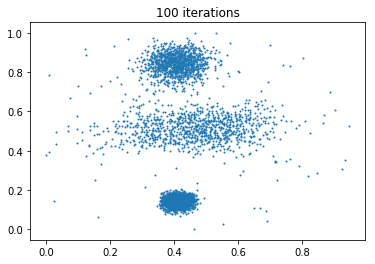

In [108]:
I.plot_graph(alpha=1)

In [102]:
I.build_graph(iterations=500)

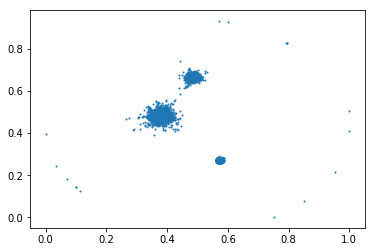

In [103]:
I.plot_graph(alpha=1)